In [1]:
import pickle
import pandas as pd
import folium
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")
import re
import seaborn as sns
import numpy as np
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None  # default='warn'
from IPython.display import clear_output
import geopandas as gpd
from functools import partial
import contextily as cx

import sys
sys.path.append("../")
import src.supportClean as sc

import sys
sys.path.append("../")
import src.bibliotheque as bb

import sys
sys.path.append("../")
import src.supportCharts as sch

In [2]:
from geopy import Nominatim
locator = Nominatim(user_agent="myGeocoder")

# data input

In [3]:
df_original = pd.read_json('../data/tripadvisor/tripadvisor_.json')
print(df_original.shape)
df_original.head()

(10587, 5)


name_raw  \
0  <a href="/Restaurant_Review-g187514-d2006562-R...   
1  <a href="/Restaurant_Review-g187514-d23446200-...   
2  <a href="/Restaurant_Review-g187514-d23999961-...   
3  <a href="/Restaurant_Review-g187514-d18480953-...   
4  <a href="/Restaurant_Review-g187514-d12216862-...   

                                           price_raw  \
0  [Cerrado ahora, Española, Internacional, €€ - ...   
1           [Cerrado ahora, Argentina, Sudamericana]   
2  [Cerrado ahora, Peruana, Street food / Comida ...   
3         [Cerrado ahora, Italiana, Pizza, €€ - €€€]   
4      [Cierra en 10 minutos, Latina, Bar, €€ - €€€]   

                                             reviews  \
0  <span class="IiChw">10.747<!-- --> opiniones</...   
1   <span class="IiChw">158<!-- --> opiniones</span>   
2   <span class="IiChw">305<!-- --> opiniones</span>   
3   <span class="IiChw">720<!-- --> opiniones</span>   
4  <span class="IiChw">3806<!-- --> opiniones</span>   

                                          rating_raw  \
0  <span class="GmcgY"><svg class="UctUV d H0" vi...   
1  <span class="GmcgY"><svg class="UctUV d H0" vi...   
2  <span class="GmcgY"><svg class="UctUV d H0" vi...   
3  <span class="GmcgY"><svg class="UctUV d H0" vi...   
4  <span class="GmcgY"><svg class="UctUV d H0" vi...   

                                                 url  
0  /Restaurant_Review-g187514-d2006562-Reviews-Lo...  
1  /Restaurant_Review-g187514-d23446200-Reviews-E...  
2  /Restaurant_Review-g187514-d23999961-Reviews-L...  
3  /Restaurant_Review-g187514-d18480953-Reviews-P...  
4  /Restaurant_Review-g187514-d12216862-Reviews-G...

In [4]:
df_enriched = pd.read_json('../data/tripadvisor/restaurants.json')
print(df_enriched.shape)
df_enriched.head()

(9600, 17)


name                                                url  \
0  Los Montes de Galicia  /Restaurant_Review-g187514-d2006562-Reviews-Lo...   
1       Empanadas Malvón  /Restaurant_Review-g187514-d23446200-Reviews-E...   
2  La Bajada Street Food  /Restaurant_Review-g187514-d23999961-Reviews-L...   
3              Pastamore  /Restaurant_Review-g187514-d18480953-Reviews-P...   
4           Grama Lounge  /Restaurant_Review-g187514-d12216862-Reviews-G...   

              province    city  \
0  Comunidad de Madrid  Madrid   
1  Comunidad de Madrid  Madrid   
2  Comunidad de Madrid  Madrid   
3  Comunidad de Madrid  Madrid   
4  Comunidad de Madrid  Madrid   

                                           price_all      price  \
0  [<span class="DsyBj DxyfE"><a class="dlMOJ" hr...   €€ - €€€   
1  [<span class="DsyBj DxyfE"><a class="dlMOJ" hr...  Argentina   
2  [<span class="DsyBj DxyfE"><a class="dlMOJ" hr...    Peruana   
3  [<span class="DsyBj DxyfE"><a class="dlMOJ" hr...   €€ - €€€   
4  [<span class="DsyBj DxyfE"><a class="dlMOJ" hr...   €€ - €€€   

                                           direction  latitude  longitude  \
0        Calle Azcona 46 PISO 8, 28028 Madrid España       NaN        NaN   
1            Calle de Luchana 3, 28010 Madrid España       NaN        NaN   
2  Calla Alcalá 414. Ciudad lineal dentro del cen...       NaN        NaN   
3             Calle Alcalá, 191, 28009 Madrid España       NaN        NaN   
4           Calle de la Cruz 19, 28012 Madrid España       NaN        NaN   

                                            cuisines           meals  \
0   Española, Internacional, Mediterránea, Saludable            None   
1                            Argentina, Sudamericana  Comidas, Cenas   
2  Peruana, Street food / Comida en la calle, Sud...  Comidas, Cenas   
3  Italiana, Pizza, Mediterránea, Saludable, Tosc...            None   
4                            Latina, Bar, Venezolana            None   

                                        specialDiets priceRangeNum  \
0                                               None   50 € - 80 €   
1                                               None          None   
2                                               None          None   
3  Opciones vegetarianas, Opciones veganas, Opcio...   15 € - 23 €   
4                                               None    5 € - 18 €   

   locationAll  coordinates               rating  positionlink  
0          NaN          NaN  [5,0 de 5 burbujas]           NaN  
1          NaN          NaN  [5,0 de 5 burbujas]           NaN  
2          NaN          NaN  [5,0 de 5 burbujas]           NaN  
3          NaN          NaN  [5,0 de 5 burbujas]           NaN  
4          NaN          NaN  [5,0 de 5 burbujas]           NaN

In [5]:
df = df_original.merge(df_enriched, left_on='url', right_on='url', how = 'right', indicator = True)
df['_merge'].value_counts()

both          9601
left_only        0
right_only       0
Name: _merge, dtype: int64

In [6]:
print(df.shape)
df.head(1)

(9601, 22)


name_raw  \
0  <a href="/Restaurant_Review-g187514-d2006562-R...   

                                           price_raw  \
0  [Cerrado ahora, Española, Internacional, €€ - ...   

                                             reviews  \
0  <span class="IiChw">10.747<!-- --> opiniones</...   

                                          rating_raw  \
0  <span class="GmcgY"><svg class="UctUV d H0" vi...   

                                                 url                   name  \
0  /Restaurant_Review-g187514-d2006562-Reviews-Lo...  Los Montes de Galicia   

              province    city  \
0  Comunidad de Madrid  Madrid   

                                           price_all     price  \
0  [<span class="DsyBj DxyfE"><a class="dlMOJ" hr...  €€ - €€€   

                                     direction  latitude  longitude  \
0  Calle Azcona 46 PISO 8, 28028 Madrid España       NaN        NaN   

                                           cuisines meals specialDiets  \
0  Española, Internacional, Mediterránea, Saludable  None         None   

  priceRangeNum  locationAll  coordinates               rating  positionlink  \
0   50 € - 80 €          NaN          NaN  [5,0 de 5 burbujas]           NaN   

  _merge  
0   both

# cleaning

## price categories
checking the price categories, there are less categories than on the original file. We will need to evaluate if it's possible to split the data to get another category in the `€€` cone more equivalent to a medium-high price range.

In [7]:
df['priceRange_clean'] = df['price'].str.extract(r'(€{1,})')
df['priceRange_clean'].value_counts()

€€      4995
€       1785
€€€€     332
Name: priceRange_clean, dtype: int64

In [8]:
df['min_PriceRangeNum'] = df['priceRangeNum'].str.extract(r'(.*)€ - .*€').astype(float)
df['max_PriceRangeNum'] = df['priceRangeNum'].str.extract(r'.*€ - (.*)€').astype(float)
df['avg_PriceRangeNum'] = df[["min_PriceRangeNum","max_PriceRangeNum"]].mean(axis = 1)
df[['avg_PriceRangeNum', 'priceRange_clean']].value_counts()

avg_PriceRangeNum  priceRange_clean
20.0               €€                  177
15.0               €€                  144
17.5               €€                  139
25.0               €€                  117
12.5               €€                  113
                                      ... 
51.0               €€€€                  1
50.5               €€                    1
49.5               €€€€                  1
49.0               €€€€                  1
301.0              €€€€                  1
Length: 258, dtype: int64

In [9]:
df[df['priceRange_clean']=='€€']['avg_PriceRangeNum'].value_counts()

20.0     177
15.0     144
17.5     139
25.0     117
12.5     113
        ... 
118.0      1
92.5       1
72.0       1
74.0       1
44.0       1
Name: avg_PriceRangeNum, Length: 119, dtype: int64

In [10]:
df_modified = df[df['priceRange_clean'] == '€€']
df_notmodified = df[df['priceRange_clean'] != '€€']

In [11]:
df_modified['avg_PriceRangeNum'].mean()

21.101611635220127

In [12]:
df_modified['priceRange_clean'] = np.where((df_modified['avg_PriceRangeNum'] > df_modified['avg_PriceRangeNum'].mean()), '€€€', '€€')

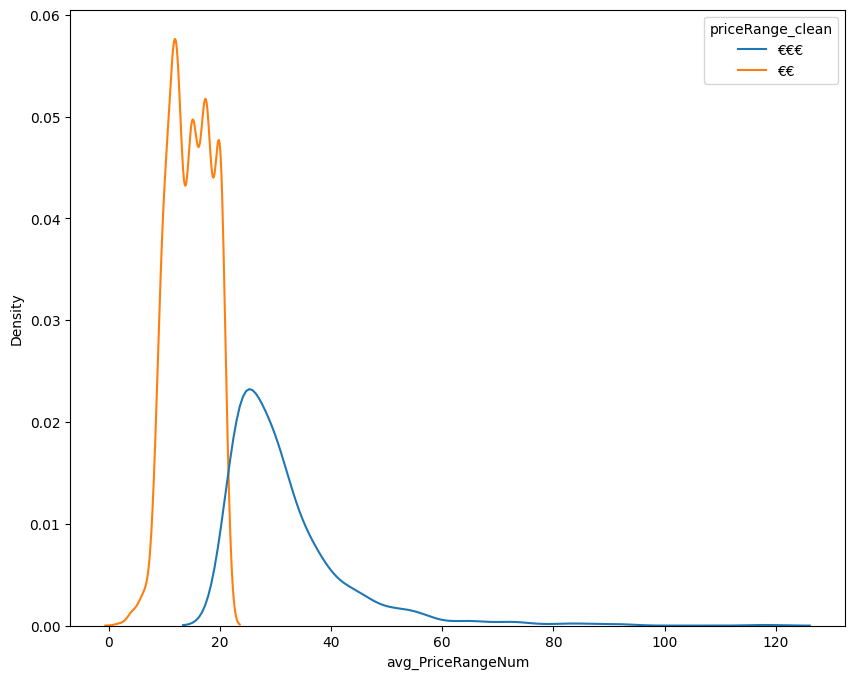

In [13]:
sns.kdeplot(data=df_modified, hue='priceRange_clean', x='avg_PriceRangeNum');

In [14]:
df = pd.concat([df_modified, df_notmodified], axis = 0)
df.shape

(9601, 26)

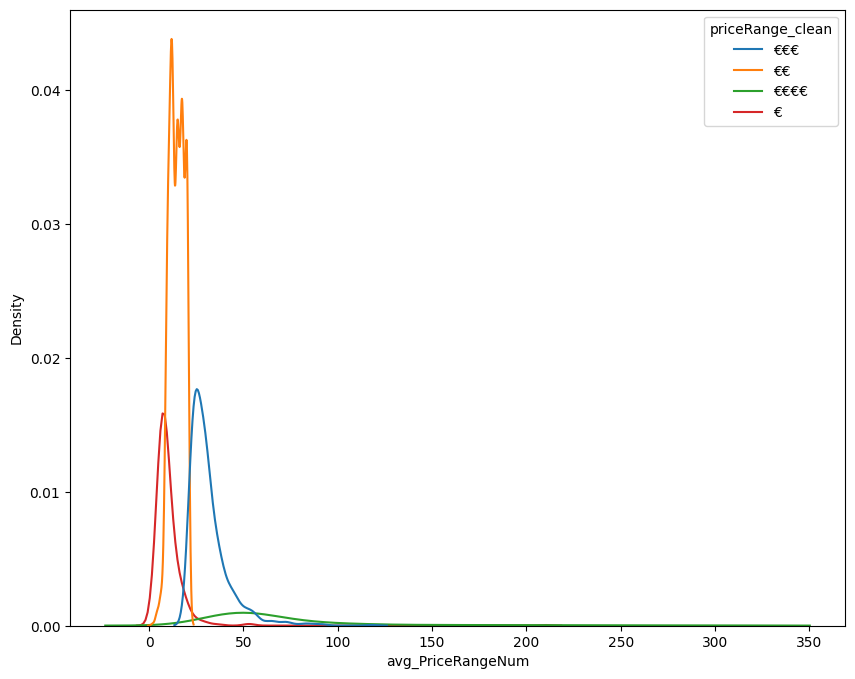

In [15]:
sns.kdeplot(data=df, hue='priceRange_clean', x='avg_PriceRangeNum');

In [16]:
df['priceRange_clean'].value_counts()

€€      4033
€       1785
€€€      962
€€€€     332
Name: priceRange_clean, dtype: int64

## reviews

In [17]:
df.head(1)

name_raw  \
0  <a href="/Restaurant_Review-g187514-d2006562-R...   

                                           price_raw  \
0  [Cerrado ahora, Española, Internacional, €€ - ...   

                                             reviews  \
0  <span class="IiChw">10.747<!-- --> opiniones</...   

                                          rating_raw  \
0  <span class="GmcgY"><svg class="UctUV d H0" vi...   

                                                 url                   name  \
0  /Restaurant_Review-g187514-d2006562-Reviews-Lo...  Los Montes de Galicia   

              province    city  \
0  Comunidad de Madrid  Madrid   

                                           price_all     price  \
0  [<span class="DsyBj DxyfE"><a class="dlMOJ" hr...  €€ - €€€   

                                     direction  latitude  longitude  \
0  Calle Azcona 46 PISO 8, 28028 Madrid España       NaN        NaN   

                                           cuisines meals specialDiets  \
0  Española, Internacional, Mediterránea, Saludable  None         None   

  priceRangeNum  locationAll  coordinates               rating  positionlink  \
0   50 € - 80 €          NaN          NaN  [5,0 de 5 burbujas]           NaN   

  _merge priceRange_clean  min_PriceRangeNum  max_PriceRangeNum  \
0   both              €€€               50.0               80.0   

   avg_PriceRangeNum  
0               65.0

In [18]:
df['reviews_clean'] = df['reviews'].str.extract(r'">(.*)<!-- -->.*</')[0].str.replace('.','')

## rating

In [19]:
df.head(1)

name_raw  \
0  <a href="/Restaurant_Review-g187514-d2006562-R...   

                                           price_raw  \
0  [Cerrado ahora, Española, Internacional, €€ - ...   

                                             reviews  \
0  <span class="IiChw">10.747<!-- --> opiniones</...   

                                          rating_raw  \
0  <span class="GmcgY"><svg class="UctUV d H0" vi...   

                                                 url                   name  \
0  /Restaurant_Review-g187514-d2006562-Reviews-Lo...  Los Montes de Galicia   

              province    city  \
0  Comunidad de Madrid  Madrid   

                                           price_all     price  \
0  [<span class="DsyBj DxyfE"><a class="dlMOJ" hr...  €€ - €€€   

                                     direction  latitude  longitude  \
0  Calle Azcona 46 PISO 8, 28028 Madrid España       NaN        NaN   

                                           cuisines meals specialDiets  \
0  Española, Internacional, Mediterránea, Saludable  None         None   

  priceRangeNum  locationAll  coordinates               rating  positionlink  \
0   50 € - 80 €          NaN          NaN  [5,0 de 5 burbujas]           NaN   

  _merge priceRange_clean  min_PriceRangeNum  max_PriceRangeNum  \
0   both              €€€               50.0               80.0   

   avg_PriceRangeNum reviews_clean  
0               65.0         10747

In [20]:
type(df['rating'][0][0])

str

In [21]:
df['rating'].value_counts()

[4,0 de 5 burbujas]     2607
[4,5 de 5 burbujas]     1952
[3,5 de 5 burbujas]     1796
[5,0 de 5 burbujas]     1103
[3,0 de 5 burbujas]     1014
[2,5 de 5 burbujas]      448
[-1,0 de 5 burbujas]     255
[2,0 de 5 burbujas]      230
[1,0 de 5 burbujas]      113
[1,5 de 5 burbujas]       66
[]                        16
[0 opiniones]              1
Name: rating, dtype: int64

In [22]:
df['rating_clean'] = df['rating'].explode().replace(bb.ratings)

In [23]:
df.head(1)

name_raw  \
0  <a href="/Restaurant_Review-g187514-d2006562-R...   

                                           price_raw  \
0  [Cerrado ahora, Española, Internacional, €€ - ...   

                                             reviews  \
0  <span class="IiChw">10.747<!-- --> opiniones</...   

                                          rating_raw  \
0  <span class="GmcgY"><svg class="UctUV d H0" vi...   

                                                 url                   name  \
0  /Restaurant_Review-g187514-d2006562-Reviews-Lo...  Los Montes de Galicia   

              province    city  \
0  Comunidad de Madrid  Madrid   

                                           price_all     price  \
0  [<span class="DsyBj DxyfE"><a class="dlMOJ" hr...  €€ - €€€   

                                     direction  latitude  longitude  \
0  Calle Azcona 46 PISO 8, 28028 Madrid España       NaN        NaN   

                                           cuisines meals specialDiets  \
0  Española, Internacional, Mediterránea, Saludable  None         None   

  priceRangeNum  locationAll  coordinates               rating  positionlink  \
0   50 € - 80 €          NaN          NaN  [5,0 de 5 burbujas]           NaN   

  _merge priceRange_clean  min_PriceRangeNum  max_PriceRangeNum  \
0   both              €€€               50.0               80.0   

   avg_PriceRangeNum reviews_clean  rating_clean  
0               65.0         10747           5.0

# geolocation

In [24]:
df['direction_clean'] = df['direction'].str.lower().str.findall(r'(.*\d{1,3})\W?.*(\d{5} madrid españa)').explode().str.join(', ')
df['direction_clean'].value_counts()

calle calderilla, 1, 28054 madrid españa                      11
calle vallehermoso 36, 28015 madrid españa                     9
calle calderilla 1, 28054 madrid españa                        9
paseo castellana 89, 28046 madrid españa                       8
calle ayala 28, 28001 madrid españa                            7
                                                              ..
calle del alcalde sáinz de baranda 12, 28009 madrid españa     1
calle nuestra señora de valverde 67, 28034 madrid españa       1
calle del principe carlos 29, 28050 madrid españa              1
calle de isabel la católica, 15, 28013 madrid españa           1
ctra. griñón a el álamo km. 16,5, 28979 madrid españa          1
Name: direction_clean, Length: 8487, dtype: int64

In [25]:
df_geolocated = sc.geolocation(df, 'direction_clean')

 10%|█         | 1001/9601 [16:43<2:23:58,  1.00s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('carretera de san jerónimo 16, 28014 madrid españa',), **{}).
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/iron2/lib/python3.9/site-packages/urllib3/connectionpool.py", line 449, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/opt/homebrew/Caskroom/miniforge/base/envs/iron2/lib/python3.9/site-packages/urllib3/connectionpool.py", line 444, in _make_request
    httplib_response = conn.getresponse()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/iron2/lib/python3.9/http/client.py", line 1377, in getresponse
    response.begin()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/iron2/lib/python3.9/http/client.py", line 320, in begin
    version, status, reason = self._read_status()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/iron2/lib/python3.9/http/client.py", line 281, in 

In [26]:
print('location null:', df[df['location'].isnull() == True].shape, 'coordinates null:', df[df['point'].isnull() == True].shape)

location null: (2303, 32) coordinates null: (0, 32)


In [27]:
map1 = folium.Map(
    location=[40.41694, -3.70361],
    tiles='cartodbpositron',
    zoom_start=12,
)
df_geolocated[df_geolocated['latitude'].isnull() == False].apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(map1), axis=1)
map1

In [29]:
df_geolocated.drop(['name_raw', 'price_raw', 'reviews', 'rating_raw', 'price_all', 'locationAll', 'coordinates', 'rating', 'positionlink', '_merge'], axis = 1, inplace=True)
df_geolocated.head()

url  \
0  /Restaurant_Review-g187514-d2006562-Reviews-Lo...   
3  /Restaurant_Review-g187514-d18480953-Reviews-P...   
4  /Restaurant_Review-g187514-d12216862-Reviews-G...   
5  /Restaurant_Review-g187514-d12488993-Reviews-K...   
6  /Restaurant_Review-g187514-d11896546-Reviews-A...   

                       name             province    city     price  \
0     Los Montes de Galicia  Comunidad de Madrid  Madrid  €€ - €€€   
3                 Pastamore  Comunidad de Madrid  Madrid  €€ - €€€   
4              Grama Lounge  Comunidad de Madrid  Madrid  €€ - €€€   
5  Kathmandu Tandoori House  Comunidad de Madrid  Madrid  €€ - €€€   
6                     Ástor  Comunidad de Madrid  Madrid  €€ - €€€   

                                     direction   latitude  longitude  \
0  Calle Azcona 46 PISO 8, 28028 Madrid España        NaN        NaN   
3       Calle Alcalá, 191, 28009 Madrid España  40.420697  -3.685145   
4     Calle de la Cruz 19, 28012 Madrid España  40.415520  -3.701731   
5       Calle Acuario, 11, 28042 Madrid España  40.474371  -3.578740   
6    Calle del Almendro 9, 28005 Madrid España  40.412697  -3.709653   

                                            cuisines meals  \
0   Española, Internacional, Mediterránea, Saludable  None   
3  Italiana, Pizza, Mediterránea, Saludable, Tosc...  None   
4                            Latina, Bar, Venezolana  None   
5                 India, Asiática, Saludable, Nepalí  None   
6  Internacional, Mediterránea, Europea, Fusión, ...  None   

                                        specialDiets priceRangeNum  \
0                                               None   50 € - 80 €   
3  Opciones vegetarianas, Opciones veganas, Opcio...   15 € - 23 €   
4                                               None    5 € - 18 €   
5  Opciones vegetarianas, Opciones veganas, Opcio...   10 € - 60 €   
6  Opciones vegetarianas, Opciones veganas, Opcio...   20 € - 50 €   

  priceRange_clean  min_PriceRangeNum  max_PriceRangeNum  avg_PriceRangeNum  \
0              €€€               50.0               80.0               65.0   
3               €€               15.0               23.0               19.0   
4               €€                5.0               18.0               11.5   
5              €€€               10.0               60.0               35.0   
6              €€€               20.0               50.0               35.0   

  reviews_clean  rating_clean                              direction_clean  \
0         10747           5.0  calle azcona 46 piso 8, 28028 madrid españa   
3           720           5.0       calle alcalá, 191, 28009 madrid españa   
4          3806           5.0     calle de la cruz 19, 28012 madrid españa   
5          2576           5.0       calle acuario, 11, 28042 madrid españa   
6          1765           5.0    calle del almendro 9, 28005 madrid españa   

                                            location  \
0                                               None   
3  (Calle Alcalá, Recoletos, Salamanca, Madrid, Á...   
4  (El Jardín, 19, Calle de la Cruz, Barrio de lo...   
5  (Ganesha, 11, Calle de Acuario, Barajas, Madri...   
6  (Déjate Liar, 9, Calle del Almendro, Barrio de...   

                           point  altitude                   geometry  
0             (None, None, None)       NaN                POINT EMPTY  
3  (40.4206967, -3.6851451, 0.0)       0.0  POINT (40.42070 -3.68515)  
4  (40.4155198, -3.7017311, 0.0)       0.0  POINT (40.41552 -3.70173)  
5     (40.474371, -3.57874, 0.0)       0.0  POINT (40.47437 -3.57874)  
6   (40.412697, -3.7096528, 0.0)       0.0  POINT (40.41270 -3.70965)

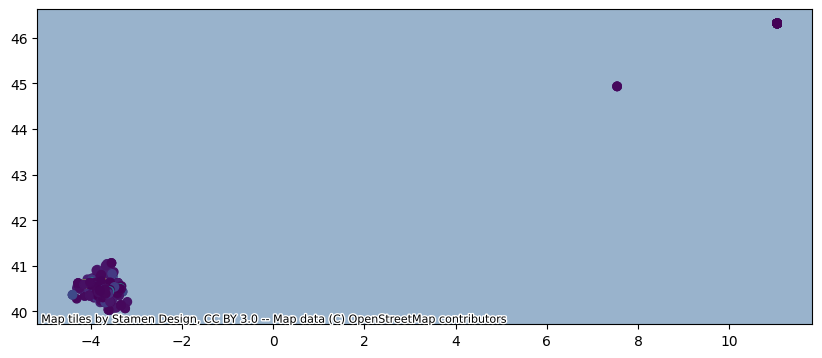

In [30]:
gdf_geolocated = gpd.GeoDataFrame(df_geolocated, geometry=gpd.points_from_xy(df_geolocated.longitude, df_geolocated.latitude)).set_crs('epsg:4326')
ax = gdf_geolocated.to_crs(epsg=4326).plot(column='avg_PriceRangeNum', cmap=None)
cx.add_basemap(ax)

In [31]:
gdf_geolocated[~gdf_geolocated.is_empty]

url  \
3     /Restaurant_Review-g187514-d18480953-Reviews-P...   
4     /Restaurant_Review-g187514-d12216862-Reviews-G...   
5     /Restaurant_Review-g187514-d12488993-Reviews-K...   
6     /Restaurant_Review-g187514-d11896546-Reviews-A...   
7     /Restaurant_Review-g187514-d17340009-Reviews-Z...   
...                                                 ...   
9595  /Restaurant_Review-g187514-d21386306-Reviews-B...   
9596  /Restaurant_Review-g187514-d16808393-Reviews-R...   
9598  /Restaurant_Review-g187514-d24060928-Reviews-S...   
9599  /Restaurant_Review-g187514-d22950737-Reviews-M...   
9600  /Restaurant_Review-g187514-d22950737-Reviews-M...   

                           name             province    city     price  \
3                     Pastamore  Comunidad de Madrid  Madrid  €€ - €€€   
4                  Grama Lounge  Comunidad de Madrid  Madrid  €€ - €€€   
5      Kathmandu Tandoori House  Comunidad de Madrid  Madrid  €€ - €€€   
6                         Ástor  Comunidad de Madrid  Madrid  €€ - €€€   
7     Zenith Brunch & Cocktails  Comunidad de Madrid  Madrid  €€ - €€€   
...                         ...                  ...     ...       ...   
9595                    Bokkato  Comunidad de Madrid  Madrid      None   
9596                    Rubimar  Comunidad de Madrid  Madrid      None   
9598                  Sanabowls  Comunidad de Madrid  Madrid      None   
9599                 McDonald's  Comunidad de Madrid  Madrid      None   
9600                 McDonald's  Comunidad de Madrid  Madrid      None   

                                              direction   latitude  longitude  \
3                Calle Alcalá, 191, 28009 Madrid España  40.420697  -3.685145   
4              Calle de la Cruz 19, 28012 Madrid España  40.415520  -3.701731   
5                Calle Acuario, 11, 28042 Madrid España  40.474371  -3.578740   
6             Calle del Almendro 9, 28005 Madrid España  40.412697  -3.709653   
7                Calle Valverde 28, 28004 Madrid España  40.422439  -3.701617   
...                                                 ...        ...        ...   
9595  Calle de San Vicente Ferrer, 8, 28004 Madrid E...  40.425761  -3.703859   
9596       Calle Tomás Redondo N 3, 28033 Madrid España  40.471711  -3.629169   
9598        C. de Vallehermoso, 42, 28015 Madrid España  40.435018  -3.708465   
9599      Calle de San Romualdo 22, 28037 Madrid España  40.435976  -3.620513   
9600      Calle de San Romualdo 22, 28037 Madrid España  40.435976  -3.620513   

                                               cuisines           meals  \
3     Italiana, Pizza, Mediterránea, Saludable, Tosc...            None   
4                               Latina, Bar, Venezolana            None   
5                    India, Asiática, Saludable, Nepalí            None   
6     Internacional, Mediterránea, Europea, Fusión, ...            None   
7               Café, Europea, Saludable, Internacional            None   
...                                                 ...             ...   
9595                                               None            None   
9596                                               None            None   
9598                                               None  Comidas, Cenas   
9599                                               None            None   
9600                                               None            None   

                                           specialDiets priceRangeNum  \
3     Opciones vegetarianas, Opciones veganas, Opcio...   15 € - 23 €   
4                                                  None    5 € - 18 €   
5     Opciones vegetarianas, Opciones veganas, Opcio...   10 € - 60 €   
6     Opciones vegetarianas, Opciones veganas, Opcio...   20 € - 50 €   
7                                                  None    8 € - 12 €   
...                                                 ...           ...   
9595                                               None          None

# EDA

In [34]:
sch.analisis_basico(df_geolocated.drop(['geometry', 'location'], axis =1))

_________________________________

1_Data Structure: (9601, 21)


url                   name  \
0  /Restaurant_Review-g187514-d2006562-Reviews-Lo...  Los Montes de Galicia   
3  /Restaurant_Review-g187514-d18480953-Reviews-P...              Pastamore   

              province    city     price  \
0  Comunidad de Madrid  Madrid  €€ - €€€   
3  Comunidad de Madrid  Madrid  €€ - €€€   

                                     direction   latitude  longitude  \
0  Calle Azcona 46 PISO 8, 28028 Madrid España        NaN        NaN   
3       Calle Alcalá, 191, 28009 Madrid España  40.420697  -3.685145   

                                            cuisines meals  \
0   Española, Internacional, Mediterránea, Saludable  None   
3  Italiana, Pizza, Mediterránea, Saludable, Tosc...  None   

                                        specialDiets priceRangeNum  \
0                                               None   50 € - 80 €   
3  Opciones vegetarianas, Opciones veganas, Opcio...   15 € - 23 €   

  priceRange_clean  min_PriceRangeNum  max_PriceRangeNum  avg_PriceRangeNum  \
0              €€€               50.0               80.0               65.0   
3               €€               15.0               23.0               19.0   

  reviews_clean  rating_clean                              direction_clean  \
0         10747           5.0  calle azcona 46 piso 8, 28028 madrid españa   
3           720           5.0       calle alcalá, 191, 28009 madrid españa   

                           point  altitude  
0             (None, None, None)       NaN  
3  (40.4206967, -3.6851451, 0.0)       0.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601 entries, 0 to 9600
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                9601 non-null   object 
 1   name               9585 non-null   object 
 2   province           9601 non-null   object 
 3   city               9601 non-null   object 
 4   price              8603 non-null   object 
 5   direction          9585 non-null   object 
 6   latitude           7298 non-null   float64
 7   longitude          7298 non-null   float64
 8   cuisines           8221 non-null   object 
 9   meals              5671 non-null   object 
 10  specialDiets       2248 non-null   object 
 11  priceRangeNum      3353 non-null   object 
 12  priceRange_clean   7112 non-null   object 
 13  min_PriceRangeNum  3353 non-null   float64
 14  max_PriceRangeNum  3353 non-null   float64
 15  avg_PriceRangeNum  3353 non-null   float64
 16  reviews_clean      9347 

None

_________________________________

2_Duplicated columns:
1
_________________________________

3_Null values distribution:


url    name province    city   price direction latitude longitude  \
nulos        0      16        0       0     998        16     2303      2303   
dtypes  object  object   object  object  object    object  float64   float64   

       cuisines   meals specialDiets priceRangeNum priceRange_clean  \
nulos      1380    3930         7353          6248             2489   
dtypes   object  object       object        object           object   

       min_PriceRangeNum max_PriceRangeNum avg_PriceRangeNum reviews_clean  \
nulos               6248              6248              6248           254   
dtypes           float64           float64           float64        object   

       rating_clean direction_clean   point altitude  
nulos            16             495       0     2303  
dtypes      float64          object  object  float64

_________________________________

4_Numerical variables distribution:


latitude    longitude  min_PriceRangeNum  max_PriceRangeNum  \
count  7298.000000  7298.000000        3353.000000        3353.000000   
mean     40.829831    -2.711759          12.907844          31.337608   
std       1.471071     3.686905          12.385496          31.720634   
min      40.024807    -4.493411           0.000000           1.000000   
25%      40.413532    -3.708428           5.000000          15.000000   
50%      40.427774    -3.695908          10.000000          25.000000   
75%      40.460898    -3.668442          15.000000          35.000000   
max      46.314475    11.048029         200.000000         602.000000   

       avg_PriceRangeNum  rating_clean  altitude  
count        3353.000000   9585.000000    7298.0  
mean           22.122726      3.713302       0.0  
std            20.282288      1.119650       0.0  
min             2.000000     -1.000000       0.0  
25%            11.500000      3.500000       0.0  
50%            17.500000      4.000000       0.0  
75%            26.000000      4.500000       0.0  
max           301.000000      5.000000       0.0

_________________________________

5_Categorical variables distribution:


url         name  \
count                                                9601         9585   
unique                                               9600         8848   
top     /Restaurant_Review-g187514-d22950737-Reviews-M...  Burger King   
freq                                                    2           51   

                   province    city     price  \
count                  9601    9601      8603   
unique                    1       1        58   
top     Comunidad de Madrid  Madrid  €€ - €€€   
freq                   9601    9601      4995   

                                                direction  cuisines  \
count                                                9585      8221   
unique                                               9198      2267   
top     Calle Calderilla 1 Centro Comercial Islazul, 2...  Española   
freq                                                    5      1501   

                 meals           specialDiets priceRangeNum priceRange_clean  \
count             5671                   2248          3353             7112   
unique             197                     24           679                4   
top     Comidas, Cenas  Opciones vegetarianas   10 € - 20 €               €€   
freq              1684                    705           120             4033   

       reviews_clean                           direction_clean  \
count           9347                                      9106   
unique           906                                      8487   
top                1  calle calderilla, 1, 28054 madrid españa   
freq             602                                        11   

                     point  
count                 9601  
unique                4613  
top     (None, None, None)  
freq                  2303

numeric variables distribution


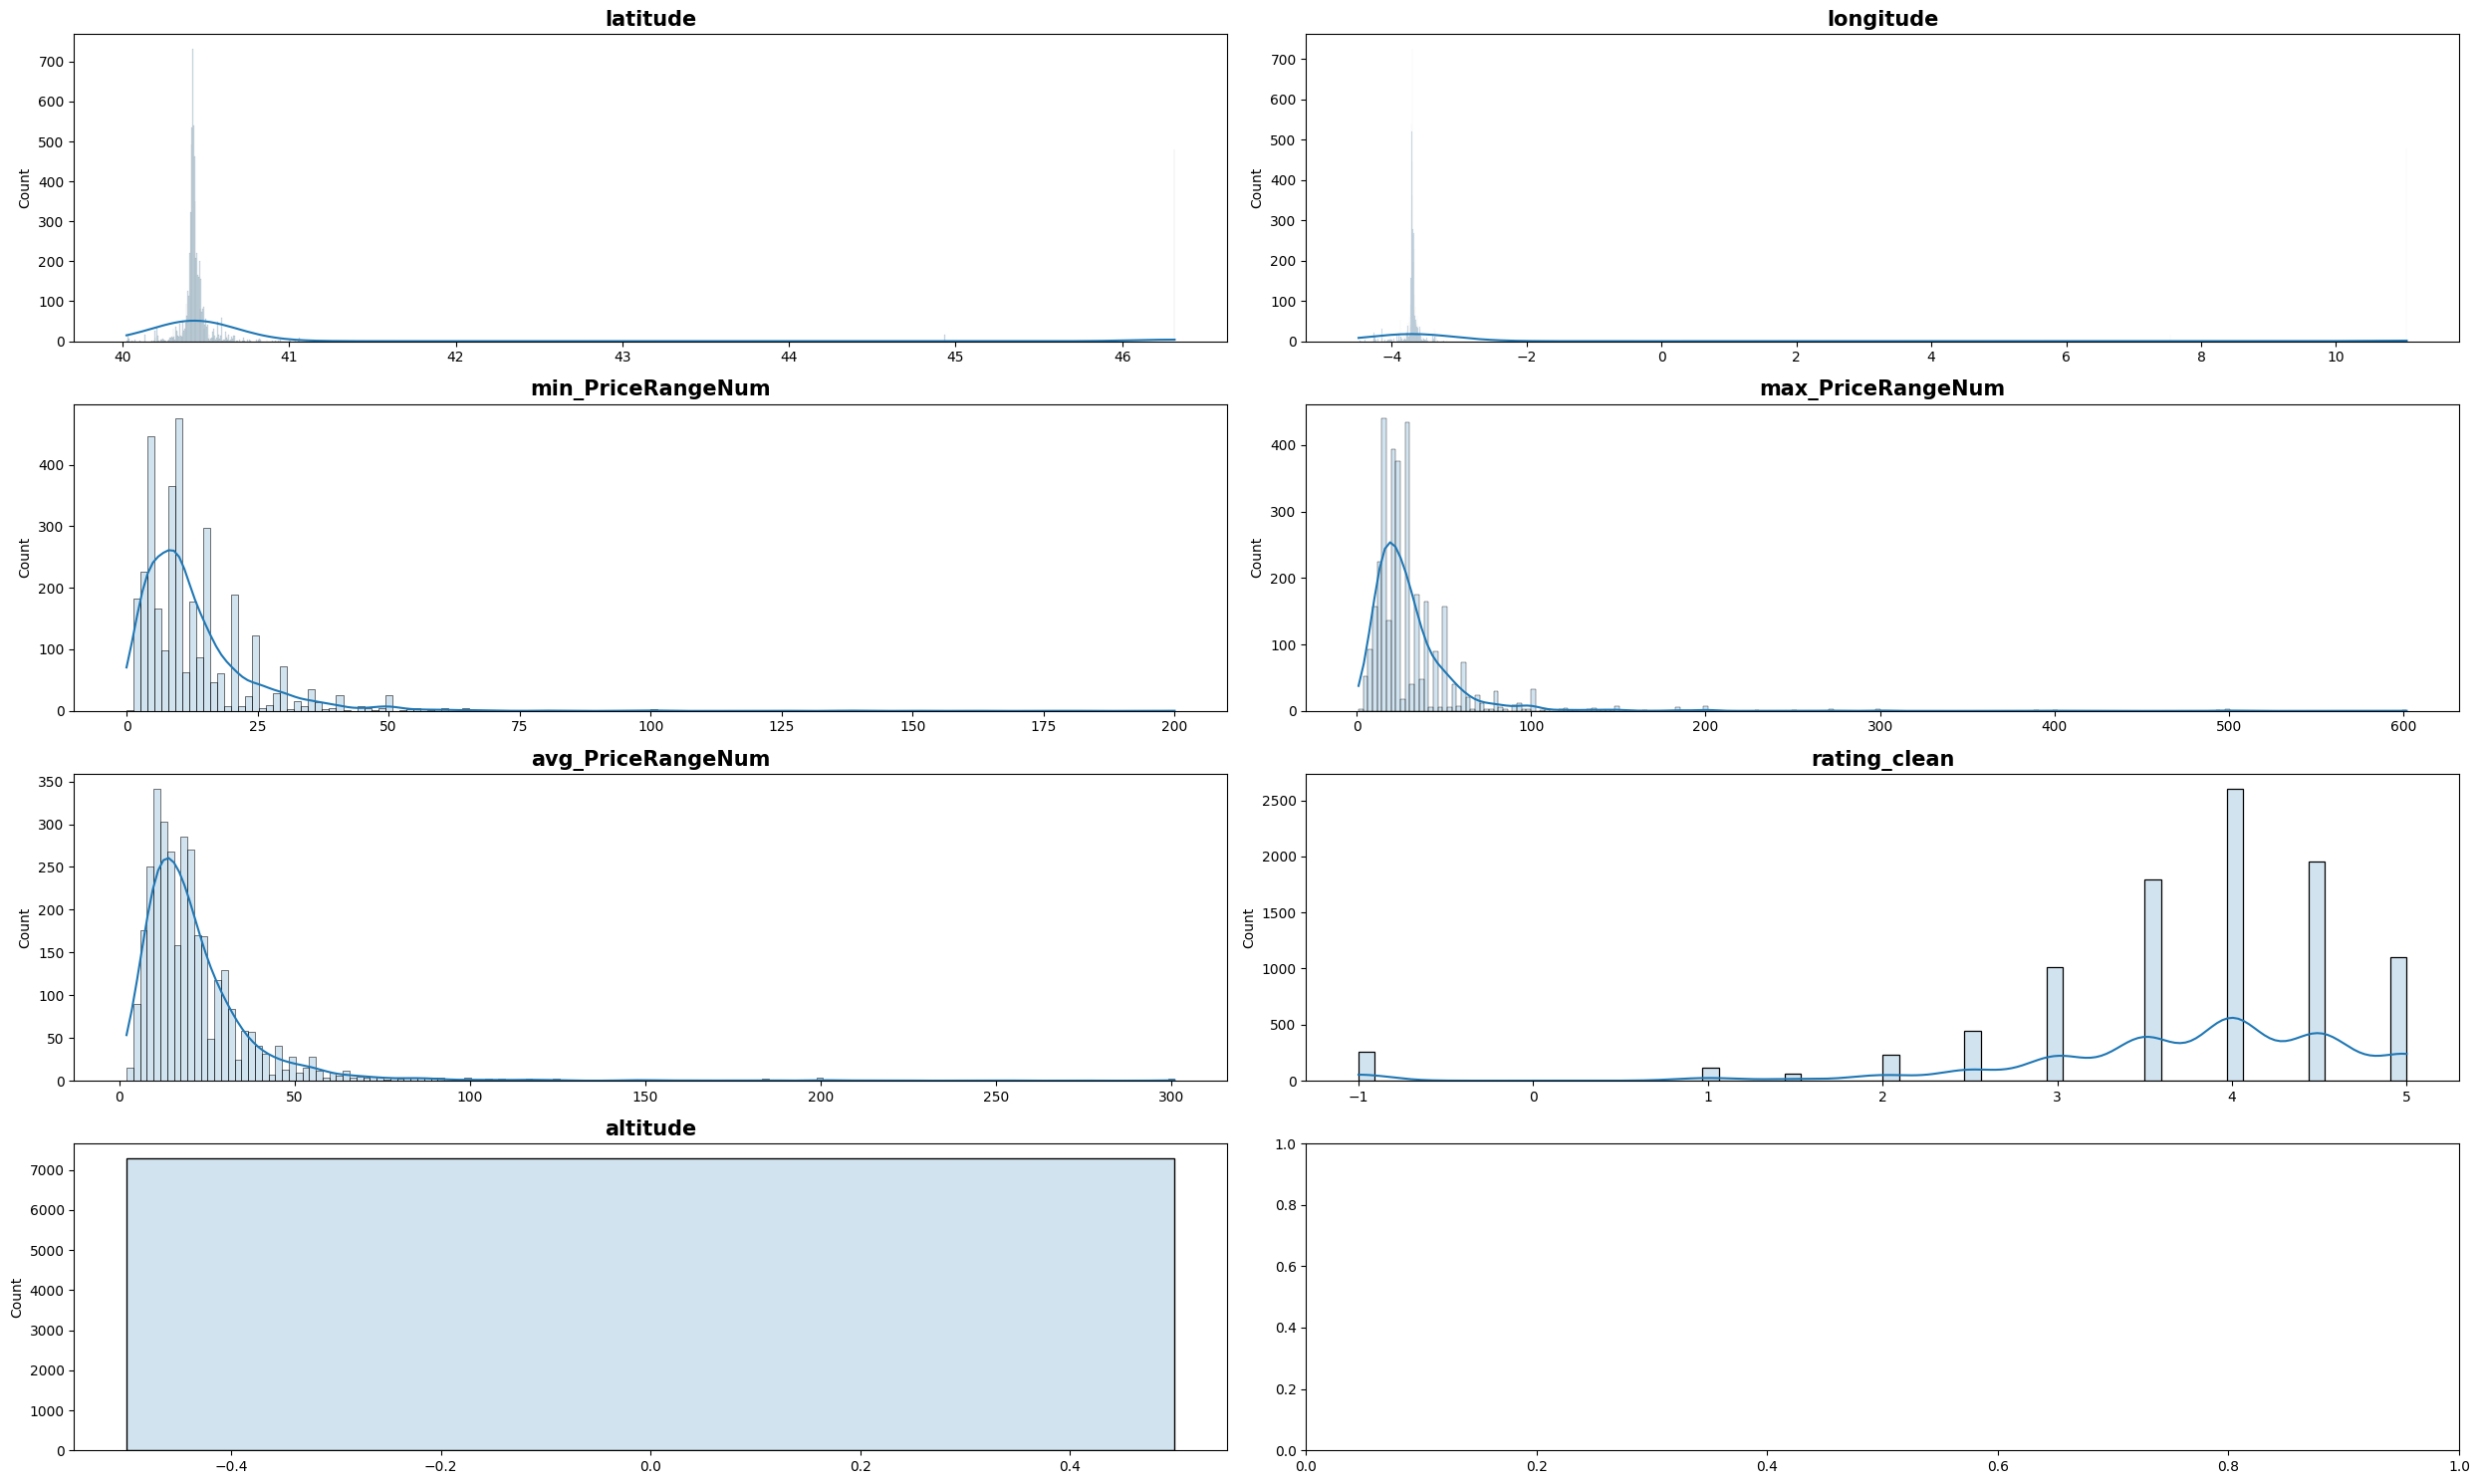

In [35]:
sch.distribucion_numericas(df_geolocated.drop(['geometry', 'location'], axis =1))

numeric variables distribution -> outliers


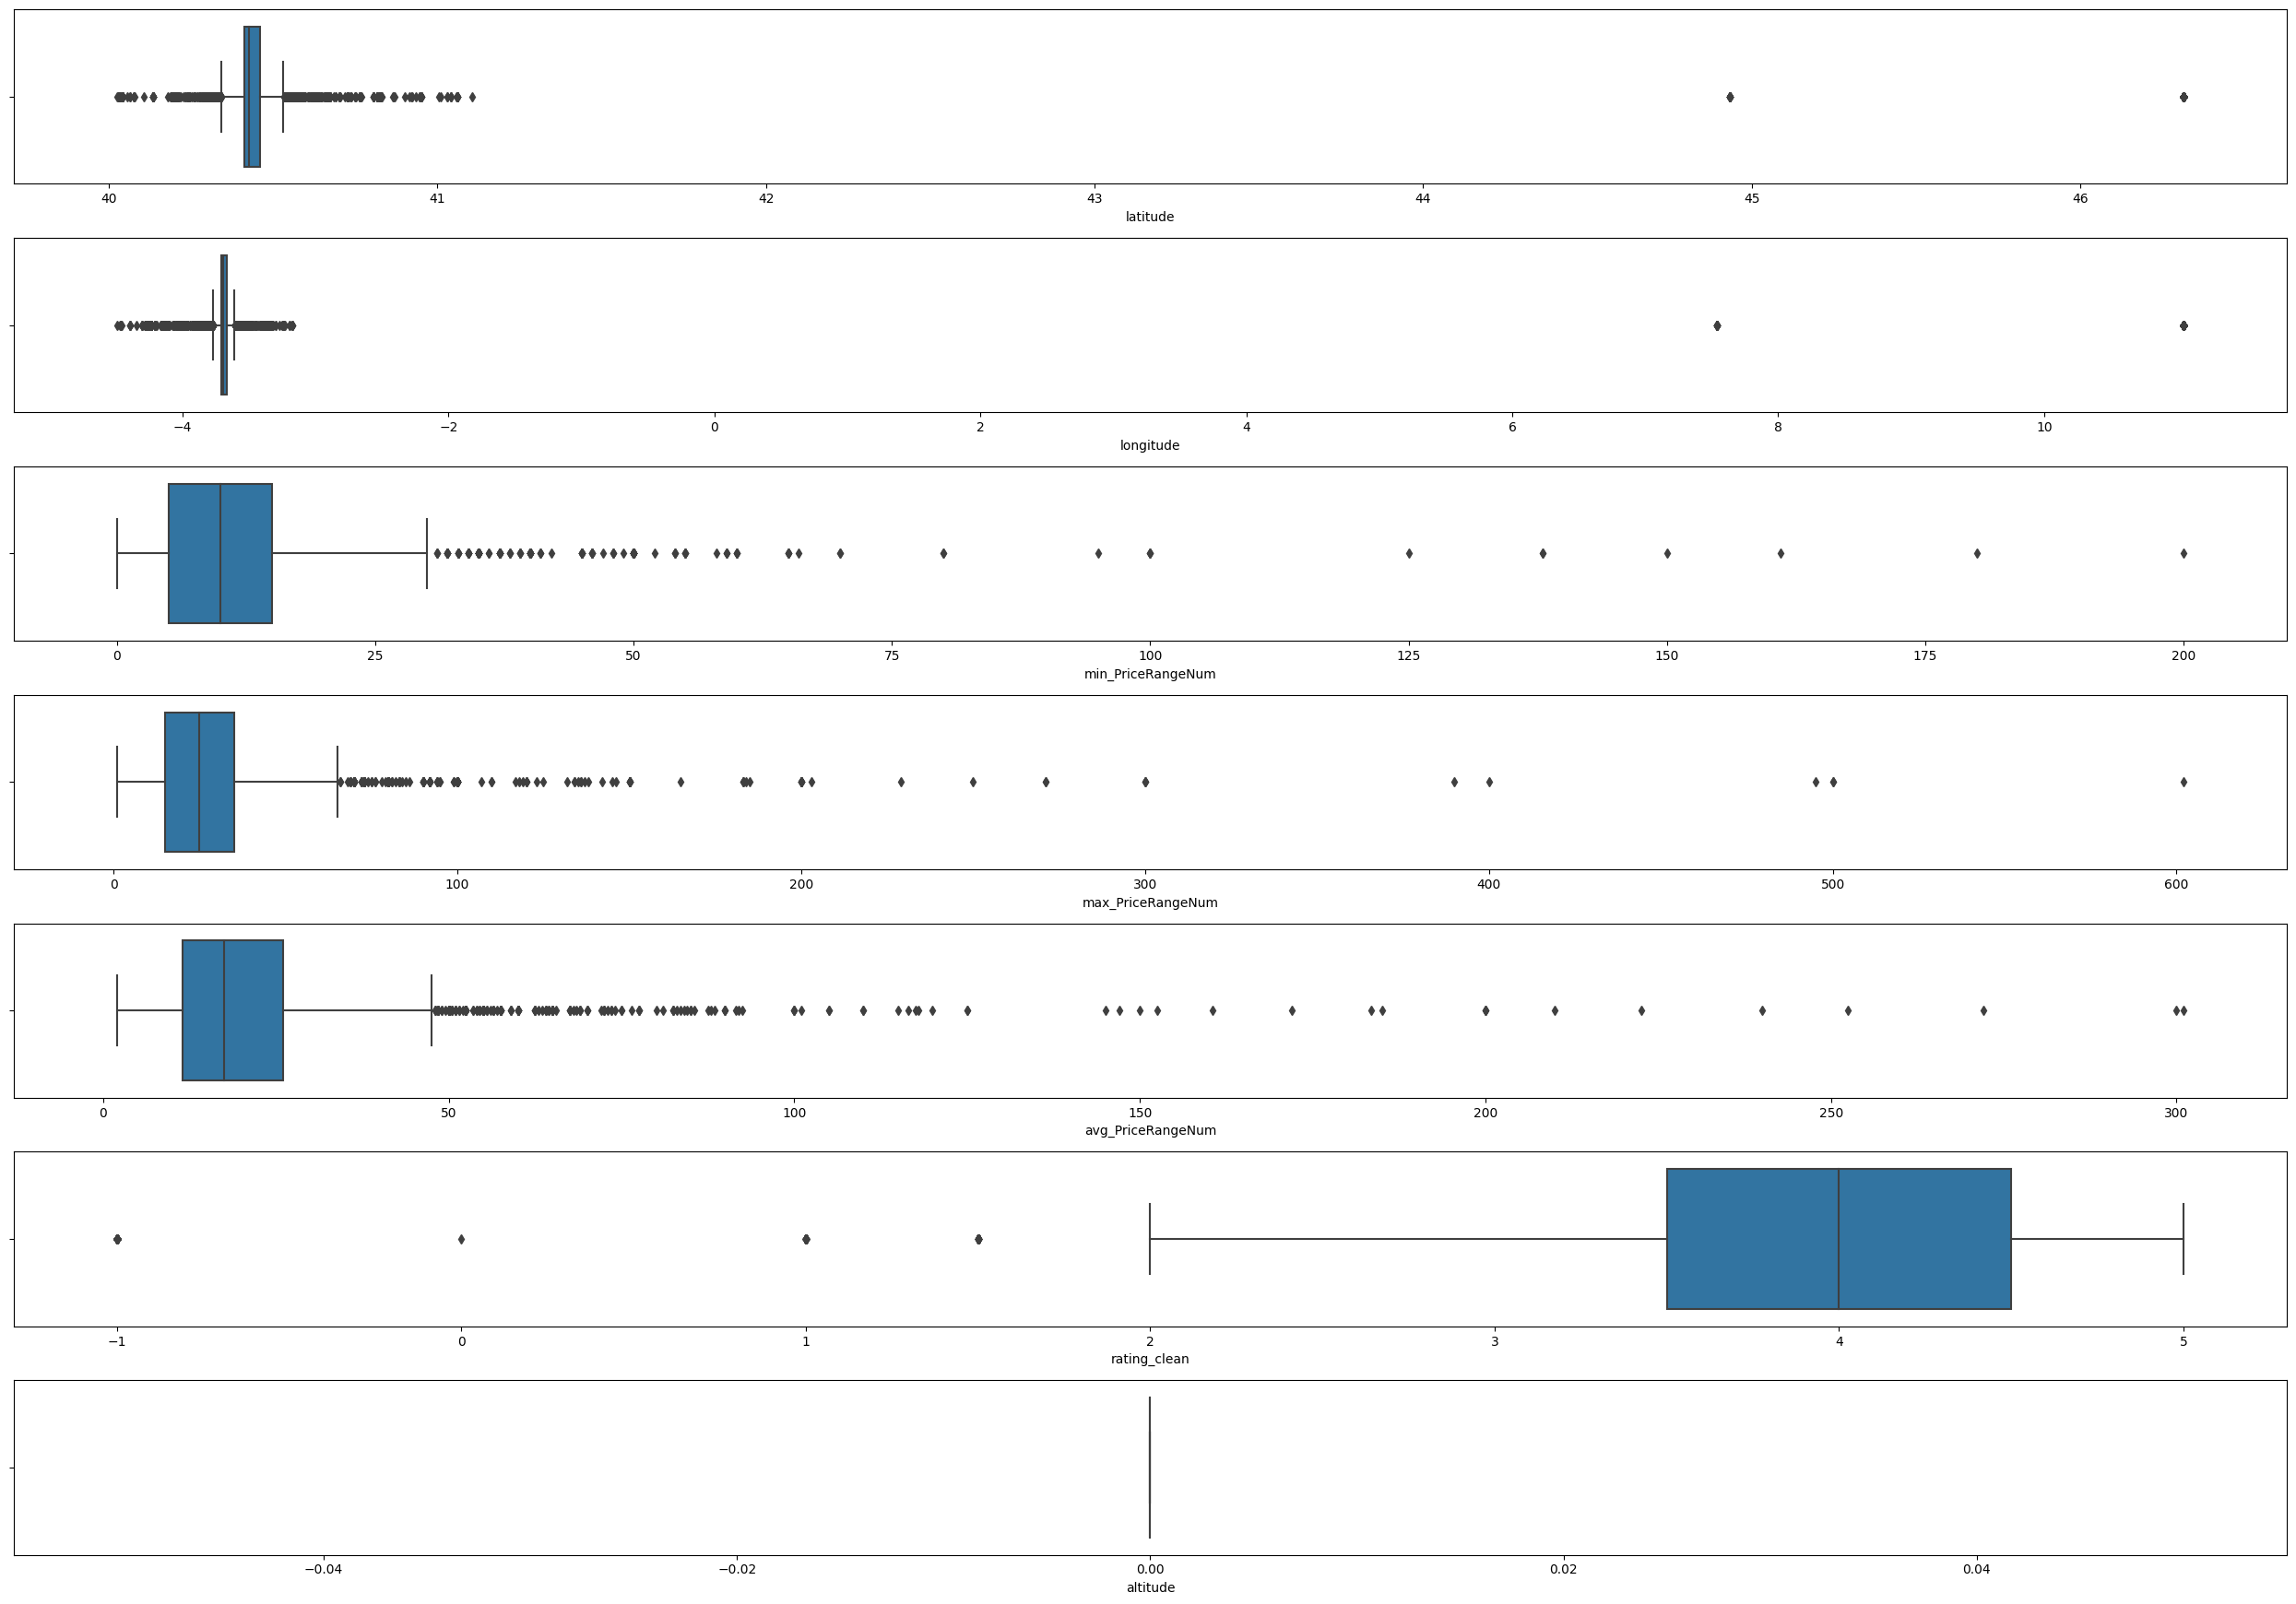

In [39]:
sch.chart_boxplot(df_geolocated.drop(['geometry', 'location'], axis =1))

# Export

In [41]:
#sc.exportFiles(gdf_geolocated, df_geolocated, 'tripadvisor')